In [1]:
import cv2
import numpy as np

import matplotlib.pyplot as plt

%matplotlib inline

In [18]:
import scipy

In [2]:
left = cv2.imread('./images/perra_7.jpg')


right = cv2.imread('./images/perra_8.jpg')

In [ ]:
cv2.imshow("right", right)

In [3]:
akaze = cv2.AKAZE_create()

kpts1, desc1 = akaze.detectAndCompute(left, None)
kpts2, desc2 = akaze.detectAndCompute(right, None)

In [ ]:
len(kpts1)

In [4]:
matcher = cv2.DescriptorMatcher_create(cv2.DescriptorMatcher_BRUTEFORCE_HAMMING)

matches = matcher.match(desc1, desc2)

In [5]:
def my_comparison(match):
    return match.distance

In [83]:
sortedmatches = sorted(matches, key=my_comparison)

nb_matches = 500
good_matches = sortedmatches[:nb_matches]

obj = []
scene = []

for i in range(len(good_matches)):

    # -- Get the keypoints from the good matches
    obj.append( kpts1[ good_matches[i].queryIdx ].pt );
    scene.append( kpts2[ good_matches[i].trainIdx ].pt );



F, mask = cv2.findFundamentalMat(np.array(obj), np.array(scene), cv2.FM_RANSAC)

correct_kpts1 = []
correct_kpts2 = []
correct_matches = []

for i in range(len(mask)):
    if mask[i,0] > 0:
        correct_kpts1.append(obj[i]);
        correct_kpts2.append(scene[i]);
        correct_matches.append(good_matches[i]);
    


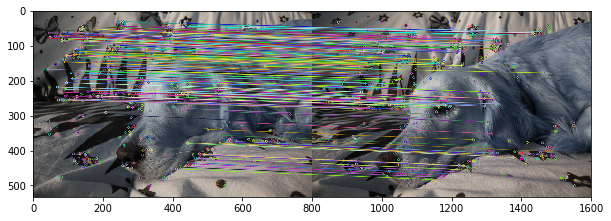

In [9]:
res = np.empty((max(left.shape[0], right.shape[0]), left.shape[1]+right.shape[1], 3), dtype=np.uint8)
cv2.drawMatches(left, kpts1, right, kpts2, correct_matches, res)
plt.figure(figsize=(10,10))
plt.imshow(res)

In [84]:
len(correct_kpts1)

402

In [12]:
k1 = np.array(correct_kpts1)

In [14]:
k1[0]

array([446.26669312,  46.37931061])

In [41]:
a = np.array([[1,2],
             [3,4]])
b = np.array([[10, 200],
              [200, 300]])
ab = np.concatenate((a.T, b.T), axis=0)

In [42]:
ab

array([[  1,   3],
       [  2,   4],
       [ 10, 200],
       [200, 300]])

In [43]:
u, s, v = np.linalg.svd(ab)

In [44]:
u

array([[-7.77670892e-03, -5.13411500e-03, -4.78291214e-02,
        -9.98812064e-01],
       [-1.11224321e-02, -3.92902200e-04, -9.98789333e-01,
         4.79166513e-02],
       [-4.54400880e-01, -8.90744013e-01,  5.78666495e-03,
         7.83946727e-03],
       [-8.90693917e-01,  4.54476170e-01,  9.93770569e-03,
         4.12292044e-03]])

In [28]:
np.linalg.inv(np.array([[1,1,1],
                       [1,1,1],
                       [1,1,1]]))

LinAlgError: Singular matrix

In [71]:
def rectify(kpts1, kpts2, img1, img2):
    """
    kpts1: numpy array of coordonnees of key points in image1, shape (nb_points, 2)
    kpts2: numpy array of coordonnees of key points in image2, shape (nb_points, 2)
    
    """
    # change the reference in image1
    x_centroids1, y_centroids1 = np.mean(kpts1, axis=0)
    
    print(x_centroids1)
    print("...........")
    print(y_centroids1)
    T1 = np.array([-x_centroids1, -y_centroids1])
    kpts1 = kpts1 + T1
    #print(kpts1)
    
    # change the reference in image2
    x_centroids2, y_centroids2 = np.mean(kpts2, axis=0)

    
    T2 = np.array([-x_centroids2, -y_centroids2])
    kpts2 = kpts2 + T2
    
    # measurement matrix
    M = np.concatenate([kpts1.T, kpts2.T], axis=0)
    #print(M)
    # Singular value decomposition of M
    U, sigma, Vh = np.linalg.svd(M)
    
    U_ = U[:, :3]
    U1 = U_[:2, :]
    U2 = U_[2:, :]
    
    # partition U_i
    A1 = U1[:2,:2]
    d1 = U1[:, 2]
    A2 = U2[:2,:2]
    d2 = U2[:, 2]
    
    # define B_i, U_1' and U_2'
    B1 = np.zeros(shape=(3,3))
    B1[-1,-1] = 1
    B1[:2,:2] = np.linalg.inv(A1)
    B1[:2, 2] = -np.dot(np.linalg.inv(A1), d1)
    
    B2 = np.zeros(shape=(3,3))
    B2[-1,-1] = 1
    B2[:2,:2] = np.linalg.inv(A2)
    B2[:2, 2] = -np.dot(np.linalg.inv(A2), d2)
    
    
    U1_prime = np.dot(U1, B2)
    U2_prime = np.dot(U2, B1)
    
    # calculate theta1, theta2
    x1 = U1_prime[0, -1]
    y1 = U1_prime[1, -1]
    theta1 = np.arctan(y1/x1)
    
    x2 = U2_prime[0, -1]
    y2 = U2_prime[1, -1]
    theta2 = np.arctan(y2/x2)
    
    # rotation matrix
    R1 = np.array([[np.cos(theta1), np.sin(theta1)],
                 [-np.sin(theta1), np.cos(theta1)]])
    
    R2 = np.array([[np.cos(theta2), np.sin(theta2)],
                 [-np.sin(theta2), np.cos(theta2)]])
    
    # calculate B and B_inv
    B = np.zeros(shape=(3,3))
    B[:2, :] = np.dot(R1, U1_prime)
    B[2, :] = np.dot(R2, U2_prime)[0, :]
    
    try:
        B_inv = np.linalg.inv(B)
    except LinAlgError:
        B[2, :] = np.array([0,0,1])
        B_inv = np.linalg.inv(B)
        
    # calculate s and H_s
    tmp = np.dot(R2, np.dot(U2_prime, B_inv))
    s = tmp[1, 1]
    
    H_s = np.array([[1, 0],
                   [0, 1./s]])
    
    # rectify I1
    translation1 = np.array([[1, 0, T1[0]],
                           [0, 1, T1[1]]])
    
    translation2 = np.array([[1, 0, T2[0]],
                           [0, 1, T2[1]]])
    
    rows,cols = img1.shape     
    
    dst1 = cv2.warpAffine(img1 , translation1, (cols,rows))
    dst2 = cv2.warpAffine(img2 , translation2, (cols,rows))
    
    r1 = np.array([[np.cos(theta1), -np.sin(theta1), 0],
                 [np.sin(theta1), np.cos(theta1), 0]])
    r2 = np.array([[np.cos(theta2), -np.sin(theta2), 0],
                 [np.sin(theta2), np.cos(theta2), 0]])
    
    dst1 = cv2.warpAffine(dst1, r1, (cols, rows))
    dst2 = cv2.warpAffine(dst2, r2, (cols, rows))
    
    dst2 = cv2.resize(dst2,None, fx=1, fy=1./s)
    
    return dst1, dst2

    
    
    

In [85]:
dst1, dst2 = rectify(np.array(correct_kpts1), np.array(correct_kpts2), cv2.cvtColor(left,cv2.COLOR_BGR2GRAY), 
                     cv2.cvtColor(right, cv2.COLOR_BGR2GRAY))

316.1109242035975
...........
208.39684790995582


In [86]:
cv2.imwrite("test1.png", dst1)

True

In [87]:
cv2.imwrite("test2.png", dst2)

True

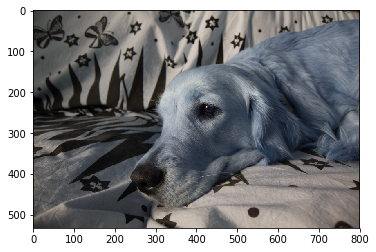

In [69]:
plt.imshow(left)

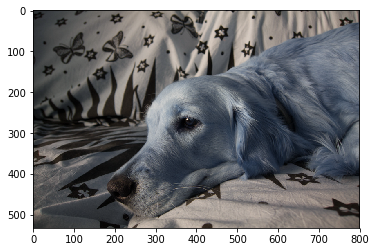

In [70]:
plt.imshow(right)